# BERT-Multilingual 

In [ ]:
!pip install transformers #from huggingface
!pip install sentencepiece

     |████████████████████████████████| 2.3MB 13.5MB/s 
     |████████████████████████████████| 901kB 48.5MB/s 
     |████████████████████████████████| 3.3MB 55.7MB/s 
     |████████████████████████████████| 1.2MB 16.1MB/s 


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
import pickle

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#os 경로 설정
path = '/gdrive/MyDrive/IBIS/IITP 감성 dataset/IBIS 감성분석 dataset/'
os.chdir(path)



In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 16 # EDA에서 추출된 Max Length

path = '/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/diabetes_SA'
os.chdir(path)
# DATA_IN_PATH = 'data_in/KOR'
# DATA_OUT_PATH = "data_out/KOR"

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

# Testing Tokenizer

In [ ]:
test_sentence = "안녕히계세요 여러분, 저는 이 모든 세상의 속박과 굴레를 벗어던지고 떠납니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 18108, 21611, 24982, 48549, 30085, 37712, 117, 9663, 11018, 9638, 25701, 9435, 70969, 9449, 118963, 11882, 8912, 56645, 11513, 9342, 12965, 23990, 68833, 9138, 118716, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 히', '# # 계', '# # 세', '# # 요', '여 러', '# # 분', ',', '저', '# # 는', '이', '모 든', '세', '# # 상 의', '속', '# # 박', '# # 과', '굴', '# # 레', '# # 를', '벗', '# # 어', '# # 던', '# # 지 고', '떠', '# # 납', '# # 니 다', '.', '[ S E P ]']


In [ ]:
kor_encode = tokenizer.encode("안녕히계세요 여러분, 저는 이 모든 세상의 속박과 굴레를 벗어던지고 떠납니다.")
eng_encode = tokenizer.encode("That's what she've been saying")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

#작동 이상무

[101, 9521, 118741, 18108, 21611, 24982, 48549, 30085, 37712, 117, 9663, 11018, 9638, 25701, 9435, 70969, 9449, 118963, 11882, 8912, 56645, 11513, 9342, 12965, 23990, 68833, 9138, 118716, 48345, 119, 102]
[101, 13646, 112, 187, 12976, 10833, 112, 10323, 10590, 22807, 102]
[CLS] 안녕히계세요 여러분, 저는 이 모든 세상의 속박과 굴레를 벗어던지고 떠납니다. [SEP]
[CLS] That's what she've been saying [SEP]


# Sentiment Classification Training



In [ ]:
# 데이터 전처리 준비
# DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
# DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

#원본
#train_data = pd.read_csv("ratings_train.txt", header = 0, delimiter = '\t', quoting = 3)

#train_data = pd.read_excel("5_total_train.xlsx") preprocessed 안된거

#preprocessed 된거

with open('preprocessed_SA','rb') as fr:
  train_data = pickle.load(fr)


train_data = train_data.dropna()
train_data.head()

#test "ratings_test.txt"

,Text,Label,text_content,content_sep,content_p
0,이거 정말 내 취향인데 역시 내 남친,Happiness,이거 정말 내 취향인데 역시 내 남친,[이 거 정말 내 취향인데 역시 내 남친],"[정말, 취향, 역시, 남자친구]"
1,이거 엄청 비싼건데 너무 고마워,Happiness,이거 엄청 비싼건데 너무 고마워,[이 거 엄청 비싼 건데 너무 고마워],"[비싸다, 고맙다]"
2,이거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이,Happiness,이거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이,[이 거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이],"[갖다, 싶다, 걸다, 어떻다, 알다, 정말, 센스]"
3,이제 재수생활 끝이다,Happiness,이제 재수생활 끝이다,[이제 재수 생활 끝이다],"[이제, 재수, 생활, 끝]"
4,엄마 이제 어깨 펴고 다녀 나 붙었어,Happiness,엄마 이제 어깨 펴고 다녀 나 붙었어,[엄마 이 제 어깨 펴고 다녀 나 붙었어],"[엄마, 이제, 어깨, 펴다, 다니다]"


In [ ]:
# data 기초 통계
train_data['Label'].value_counts()


Neutral      33963
Happiness    17792
Sadness      17296
Angry        16612
Surprise     14299
Fear         11419
Disgust      10749
Name: Label, dtype: int64

{'boxes': [<matplotlib.lines.Line2D at 0x7f606644c750>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6066453750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6066459790>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6066459250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f606644cc90>,
  <matplotlib.lines.Line2D at 0x7f606644cf90>]}

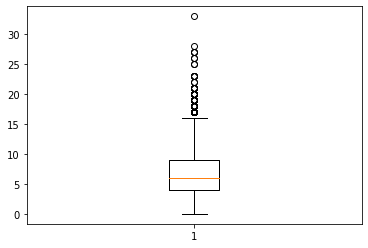

In [ ]:
# Max_len 설정 위한 max_len 추출..보다 아래  방법 활용
# #max = 0
# max = 0
# def am_i_max(x):
#   global max 
  
#   if len(x) > int(max):
#     max = len(x)
#   else:
#     pass


# #dummy.apply(lambda x: am_i_max(x))
# train_data['document'].apply(lambda x: am_i_max(x))

# 문장 길이 분포 확인하여 max_len 설정
train_data['text_len'] = train_data['content_p'].apply(lambda x: len(x))

plt.boxplot(train_data['text_len'])

# 부정적인 감성, 긍정 감정만 추출

In [ ]:
train_data = train_data[(train_data['Label'] == 'Happiness') | (train_data['Label'] == 'Sadness ') | (train_data['Label'] == 'Angry') |(train_data['Label'] == 'Fear') | (train_data['Label'] == 'Disgust')]

In [ ]:
# 긍/부 태그
train_data['label'] = (train_data['Label'] == 'Happiness')


In [ ]:
train_data['label'] = train_data['label'].apply(lambda x: int(x))
train_data

,Text,Label,text_content,content_sep,content_p,label
0,이거 정말 내 취향인데 역시 내 남친,Happiness,이거 정말 내 취향인데 역시 내 남친,[이 거 정말 내 취향인데 역시 내 남친],"[정말, 취향, 역시, 남자친구]",1
1,이거 엄청 비싼건데 너무 고마워,Happiness,이거 엄청 비싼건데 너무 고마워,[이 거 엄청 비싼 건데 너무 고마워],"[비싸다, 고맙다]",1
2,이거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이,Happiness,이거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이,[이 거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이],"[갖다, 싶다, 걸다, 어떻다, 알다, 정말, 센스]",1
3,이제 재수생활 끝이다,Happiness,이제 재수생활 끝이다,[이제 재수 생활 끝이다],"[이제, 재수, 생활, 끝]",1
4,엄마 이제 어깨 펴고 다녀 나 붙었어,Happiness,엄마 이제 어깨 펴고 다녀 나 붙었어,[엄마 이 제 어깨 펴고 다녀 나 붙었어],"[엄마, 이제, 어깨, 펴다, 다니다]",1
...,...,...,...,...,...,...
122120,너는 기자 의식도 없니 저널리즘의 기본은 사실에 기반하는 거잖아,Angry,너는 기자 의식도 없니 저널리즘의 기본은 사실에 기반하는 거잖아,[너는 기자 의식도 없니 저널리즘의 기본은 사실에 기반하는 거잖아],"[너, 기자, 의식, 없다, 저널리즘, 기본, 사실, 기반]",0
122124,기자는 사람들이 좋아하는 걸 보도하는 직업이 아니라고 기자의 정체성을 잃을 셈이야?,Angry,기자는 사람들이 좋아하는 걸 보도하는 직업이 아니라고 기자의 정체성을 잃을 셈이야,[기자는 사람들이 좋아하는 걸 보도하는 직업이 아니라 고 기자의 정체성을 잃을 셈이야],"[기자, 사람, 좋아하다, 걸, 보도, 직업, 고, 기자, 정체, 셈]",0
122126,이러다가 가짜 뉴스인 거 들키기라도 하면 너는 그대로 모가지야,Angry,이러다가 가짜 뉴스인 거 들키기라도 하면 너는 그대로 모가지야,[이러다가 가짜 뉴스인 거 들 키기라도 하면 너는 그대로 모가 지야],"[가짜, 뉴스, 인, 들다, 키기, 너, 그대로, 모, 지다]",0
122127,누가 들킨대? 너만 입 다물고 있으면 세상 사람들 아무도 몰라,Angry,누가 들킨대 너만 입 다물고 있으면 세상 사람들 아무도 몰라,[누가 들킨 대 너만 입 다물고 있으면 세상 사람들 아무도 몰라],"[누가, 들키다, 대다, 너, 입, 다물다, 세상, 사람, 아무, 몰다]",0


In [ ]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


In [ ]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [ ]:
train_data["content_joined"] = train_data["content_p"].apply(lambda x: " ".join(x))
train_data

,Text,Label,text_content,content_sep,content_p,label,content_joined
0,이거 정말 내 취향인데 역시 내 남친,Happiness,이거 정말 내 취향인데 역시 내 남친,[이 거 정말 내 취향인데 역시 내 남친],"[정말, 취향, 역시, 남자친구]",1,정말 취향 역시 남자친구
1,이거 엄청 비싼건데 너무 고마워,Happiness,이거 엄청 비싼건데 너무 고마워,[이 거 엄청 비싼 건데 너무 고마워],"[비싸다, 고맙다]",1,비싸다 고맙다
2,이거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이,Happiness,이거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이,[이 거 내가 갖고 싶었던 건지 어떻게 알았어 정말 센스쟁이],"[갖다, 싶다, 걸다, 어떻다, 알다, 정말, 센스]",1,갖다 싶다 걸다 어떻다 알다 정말 센스
3,이제 재수생활 끝이다,Happiness,이제 재수생활 끝이다,[이제 재수 생활 끝이다],"[이제, 재수, 생활, 끝]",1,이제 재수 생활 끝
4,엄마 이제 어깨 펴고 다녀 나 붙었어,Happiness,엄마 이제 어깨 펴고 다녀 나 붙었어,[엄마 이 제 어깨 펴고 다녀 나 붙었어],"[엄마, 이제, 어깨, 펴다, 다니다]",1,엄마 이제 어깨 펴다 다니다
...,...,...,...,...,...,...,...
122120,너는 기자 의식도 없니 저널리즘의 기본은 사실에 기반하는 거잖아,Angry,너는 기자 의식도 없니 저널리즘의 기본은 사실에 기반하는 거잖아,[너는 기자 의식도 없니 저널리즘의 기본은 사실에 기반하는 거잖아],"[너, 기자, 의식, 없다, 저널리즘, 기본, 사실, 기반]",0,너 기자 의식 없다 저널리즘 기본 사실 기반
122124,기자는 사람들이 좋아하는 걸 보도하는 직업이 아니라고 기자의 정체성을 잃을 셈이야?,Angry,기자는 사람들이 좋아하는 걸 보도하는 직업이 아니라고 기자의 정체성을 잃을 셈이야,[기자는 사람들이 좋아하는 걸 보도하는 직업이 아니라 고 기자의 정체성을 잃을 셈이야],"[기자, 사람, 좋아하다, 걸, 보도, 직업, 고, 기자, 정체, 셈]",0,기자 사람 좋아하다 걸 보도 직업 고 기자 정체 셈
122126,이러다가 가짜 뉴스인 거 들키기라도 하면 너는 그대로 모가지야,Angry,이러다가 가짜 뉴스인 거 들키기라도 하면 너는 그대로 모가지야,[이러다가 가짜 뉴스인 거 들 키기라도 하면 너는 그대로 모가 지야],"[가짜, 뉴스, 인, 들다, 키기, 너, 그대로, 모, 지다]",0,가짜 뉴스 인 들다 키기 너 그대로 모 지다
122127,누가 들킨대? 너만 입 다물고 있으면 세상 사람들 아무도 몰라,Angry,누가 들킨대 너만 입 다물고 있으면 세상 사람들 아무도 몰라,[누가 들킨 대 너만 입 다물고 있으면 세상 사람들 아무도 몰라],"[누가, 들키다, 대다, 너, 입, 다물다, 세상, 사람, 아무, 몰다]",0,누가 들키다 대다 너 입 다물다 세상 사람 아무 몰다


In [ ]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["content_joined"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|          | 0/56572 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 56572/56572 [00:12<00:00, 4511.27it/s]

# sents: 56572, # labels: 56572


In [ ]:
# 최대 길이: 16
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9379 119089  11903    100    102      0      0      0      0
      0      0      0      0      0      0]
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 비싸다 [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_conversaional_sentiment"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

# checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_path = os.path.join("check_points", model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)



# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

check_points/tf2_bert_conversaional_sentiment -- Folder create complete 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not ye

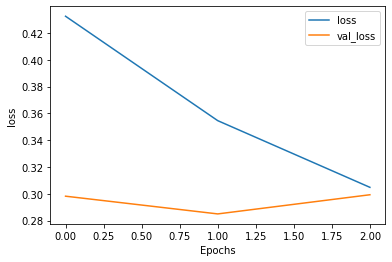

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
train_data.shape # 15만..

(56572, 7)

# Sentiment Classification Test Data

In [ ]:
#test_data = pd.read_csv("ratings_test.txt", header = 0, delimiter = '\t', quoting = 3)
#test_data = pd.read_csv("/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/preprocessed_df")
with open('/gdrive/MyDrive/석사 수업/2학기/비즈니스 텍스트마이닝/preprocessed_df', 'rb') as fr:
  test_data = pickle.load(fr)
test_data = test_data.dropna()
test_data.head()

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],"[혈당, 재기, 직전, 운동, 마치다, 저녁, 식사, 후, 말다, 앉다, 재니, 나...","[혈당, 변화]"
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],"[관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디,...","[약, 부작용, 어떻다, 하나요]"
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]","[어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈,...","[안녕하다, 당뇨, 기계, 추천, 받다, 자]"
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[의지, 전혀, 체중, 빠지다, 버리다, 마지노선, 사수, 위해, 먹다, 잡곡, 밥...","[체중, 사투, 벌이]"
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[점심, 쌀국수, 먹다, 높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복, 어렵다]",[쌀국수]


In [ ]:
test_data["content_joined"] = test_data["content_p"].apply(lambda x: " ".join(x))
test_data

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p,content_joined
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],"[혈당, 재기, 직전, 운동, 마치다, 저녁, 식사, 후, 말다, 앉다, 재니, 나...","[혈당, 변화]",혈당 재기 직전 운동 마치다 저녁 식사 후 말다 앉다 재니 나오다 이렇다 수도 두 ...
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],"[관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디,...","[약, 부작용, 어떻다, 하나요]",관리 당화 혈 색소 더 원래 먹다 약 직 듀오 서방 정 디 아미 크롱 방정 이번 새...
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]","[어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈,...","[안녕하다, 당뇨, 기계, 추천, 받다, 자]",어머니 당뇨 가지 계시다 기계 오래되다 바꾸다 드리다 싶다 채혈 아프다 않다 시험지...
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[의지, 전혀, 체중, 빠지다, 버리다, 마지노선, 사수, 위해, 먹다, 잡곡, 밥...","[체중, 사투, 벌이]",의지 전혀 체중 빠지다 버리다 마지노선 사수 위해 먹다 잡곡 밥 오늘 그램 올리다 ...
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[점심, 쌀국수, 먹다, 높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복, 어렵다]",[쌀국수],점심 쌀국수 먹다 높다 생각 후 후 쌀국수 거리 두기 공복 어렵다
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33998,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,22,≫목표몸무게 현재몸무게 표준체중,이소라 다이어트 체조 그리고 혈당기,[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당기],"[목표, 몸무게, 현재, 몸무게, 표준, 체중]","[이소라, 다이어트, 체조, 혈당]",목표 몸무게 현재 몸무게 표준 체중
33999,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,19,입원,나나의 입원일기,[입원],[나나의 입원일기],[입원],"[나나, 입원, 일기]",입원
34000,\n 당뇨병이 있을 경우 운동 시 주의사항~\n,제가 운동을 자주 하는 편입니다.,\n 천국\n,2010-08-25 16:28:00,330,0.0,10.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,16,제가 운동을 자주 하는 편입니다,당뇨병이 있을 경우 운동 시 주의사항,[제가 운동을 자주 하는 편입니다],[당뇨병이 있을 경우 운동 시 주의사항],"[운동, 자주, 편입, 니]","[당뇨병, 경우, 운동, 시, 주의, 사항]",운동 자주 편입 니
34001,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,9,새벽 반에 일어나,나나의 입원일기,[새벽 반에 일어나],[나나의 입원일기],"[새벽, 반, 일다]","[나나, 입원, 일기]",새벽 반 일다


In [ ]:
# #원본
# input_ids = []
# attention_masks = []
# token_type_ids = []
# test_data_labels = []

# for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
#     try:
#         input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

#         input_ids.append(input_id)
#         attention_masks.append(attention_mask)
#         token_type_ids.append(token_type_id)
#         test_data_labels.append(test_label)
#     except Exception as e:
#         print(e)
#         print(test_sent)
#         pass

# test_movie_input_ids = np.array(input_ids, dtype=int)
# test_movie_attention_masks = np.array(attention_masks, dtype=int)
# test_movie_type_ids = np.array(token_type_ids, dtype=int)
# test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids) # 이걸 가져와서 쓰면 됨. 

# test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

# print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
49997it [00:19, 2595.34it/s]


num sents, labels 49997, 49997


In [ ]:
#수정
input_ids = []
attention_masks = []
token_type_ids = []
#test_data_labels = []

for test_sent in tqdm(test_data["content_joined"]):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids) # 이걸 가져와서 쓰면 됨. 

#test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents {}".format(len(test_movie_input_ids)))

  0%|          | 0/34003 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 34003/34003 [00:20<00:00, 1620.87it/s]


NameError: ignored

In [ ]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 62s 1s/step - loss: 0.3302 - accuracy: 0.8587
test loss, test acc:  [0.3301541805267334, 0.8586715459823608]


In [ ]:
# 부정 document만 뽑아내기
#labels = pd.DataFrame(test_data_labels)
test_movie_inputs

(array([[   101,   9979,  21928, ..., 118738,   9486,    102],
        [   101,   8900,  12692, ...,   9707,   9111,    102],
        [   101,  96046,   9067, ...,  11903,   9318,    102],
        ...,
        [   101,   9606,  18778, ...,      0,      0,      0],
        [   101,   9415, 118984, ...,      0,      0,      0],
        [   101,   9284,  37824, ...,  41693,    102,      0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
sent_pred = cls_model.predict(test_movie_inputs,batch_size=1024)
sent_pred.shape

(34003, 2)

In [ ]:
sent_pred_df = pd.DataFrame(sent_pred,columns = ['neg','pos'])

sent_pred_df['sent_pred'] = sent_pred_df['pos'] > sent_pred_df['neg']
sent_pred_df['sent_pred'] = sent_pred_df['sent_pred'].apply(lambda x: int(x))

  
  



In [ ]:
test_data.reset_index(drop = True,inplace = True)
docus = pd.concat([test_data,sent_pred_df],axis = 1) #pd.concat([df1,df2],axis = 1) axis = 1 은 열방향.(옆에 붙이기) pd.concat([df1,df2],axis = 0) 은 행방향(밑에 붙이기)
docus

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p,content_joined,neg,pos,sent_pred
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],"[혈당, 재기, 직전, 운동, 마치다, 저녁, 식사, 후, 말다, 앉다, 재니, 나...","[혈당, 변화]",혈당 재기 직전 운동 마치다 저녁 식사 후 말다 앉다 재니 나오다 이렇다 수도 두 ...,-0.240564,-0.091820,1
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],"[관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디,...","[약, 부작용, 어떻다, 하나요]",관리 당화 혈 색소 더 원래 먹다 약 직 듀오 서방 정 디 아미 크롱 방정 이번 새...,1.570287,-1.855057,0
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]","[어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈,...","[안녕하다, 당뇨, 기계, 추천, 받다, 자]",어머니 당뇨 가지 계시다 기계 오래되다 바꾸다 드리다 싶다 채혈 아프다 않다 시험지...,0.183513,-0.491494,0
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[의지, 전혀, 체중, 빠지다, 버리다, 마지노선, 사수, 위해, 먹다, 잡곡, 밥...","[체중, 사투, 벌이]",의지 전혀 체중 빠지다 버리다 마지노선 사수 위해 먹다 잡곡 밥 오늘 그램 올리다 ...,2.397109,-2.645771,0
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[점심, 쌀국수, 먹다, 높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복, 어렵다]",[쌀국수],점심 쌀국수 먹다 높다 생각 후 후 쌀국수 거리 두기 공복 어렵다,-0.143517,-0.179952,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33998,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,22,≫목표몸무게 현재몸무게 표준체중,이소라 다이어트 체조 그리고 혈당기,[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당기],"[목표, 몸무게, 현재, 몸무게, 표준, 체중]","[이소라, 다이어트, 체조, 혈당]",목표 몸무게 현재 몸무게 표준 체중,1.245663,-1.536207,0
33999,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,19,입원,나나의 입원일기,[입원],[나나의 입원일기],[입원],"[나나, 입원, 일기]",입원,0.495256,-0.806772,0
34000,\n 당뇨병이 있을 경우 운동 시 주의사항~\n,제가 운동을 자주 하는 편입니다.,\n 천국\n,2010-08-25 16:28:00,330,0.0,10.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,16,제가 운동을 자주 하는 편입니다,당뇨병이 있을 경우 운동 시 주의사항,[제가 운동을 자주 하는 편입니다],[당뇨병이 있을 경우 운동 시 주의사항],"[운동, 자주, 편입, 니]","[당뇨병, 경우, 운동, 시, 주의, 사항]",운동 자주 편입 니,-0.595077,0.240312,1
34001,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,9,새벽 반에 일어나,나나의 입원일기,[새벽 반에 일어나],[나나의 입원일기],"[새벽, 반, 일다]","[나나, 입원, 일기]",새벽 반 일다,1.650019,-1.948385,0


In [ ]:
# 부정적인 리뷰만 추출
neg_doc = docus[docus['sent_pred'] == 0]
neg_doc.reset_index(inplace = True, drop = True)
neg_doc

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p,content_joined,neg,pos,sent_pred
0,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],"[관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디,...","[약, 부작용, 어떻다, 하나요]",관리 당화 혈 색소 더 원래 먹다 약 직 듀오 서방 정 디 아미 크롱 방정 이번 새...,1.570287,-1.855057,0
1,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]","[어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈,...","[안녕하다, 당뇨, 기계, 추천, 받다, 자]",어머니 당뇨 가지 계시다 기계 오래되다 바꾸다 드리다 싶다 채혈 아프다 않다 시험지...,0.183513,-0.491494,0
2,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[의지, 전혀, 체중, 빠지다, 버리다, 마지노선, 사수, 위해, 먹다, 잡곡, 밥...","[체중, 사투, 벌이]",의지 전혀 체중 빠지다 버리다 마지노선 사수 위해 먹다 잡곡 밥 오늘 그램 올리다 ...,2.397109,-2.645771,0
3,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[점심, 쌀국수, 먹다, 높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복, 어렵다]",[쌀국수],점심 쌀국수 먹다 높다 생각 후 후 쌀국수 거리 두기 공복 어렵다,-0.143517,-0.179952,0
4,\n 운동하면 오히려 왜혈당이 오르나요?\n,\n예전엔안그랬는데당뇨약먹고 부터는 운동 하면 혈당이더오르네요?오늘같은 경우 식전에...,\n 제라툴\n,2021-05-14 15:58:00,293,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,15,예전엔안그랬는데당뇨약먹고 부터는 운동 하면 혈당이더오르네요 오늘같은 경우 식전에 ...,운동하면 오히려 왜혈당이 오르나요,"[예전엔 안 그랬는데 당뇨약 먹고 부터는 운동 하면 혈당이 더 오르네요, 오늘 같은...",[운동하면 오히려 왜 혈당이 오르나요],"[예전, 안, 당뇨, 약, 운동, 혈당, 더, 오르다, 오늘, 경우, 식, 전, 다...","[운동, 오히려, 왜, 혈당, 오르다]",예전 안 당뇨 약 운동 혈당 더 오르다 오늘 경우 식 전 다음 혈당 재 으레 나오다...,0.201569,-0.536045,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23137,\n 26일 힘내라\n,≫아침몸무게/저녁몸무게 :68kg,\n 힘내라 나야\n,2010-08-26 15:05:00,53,0.0,2.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,15,≫아침몸무게 저녁몸무게,힘내라,[≫아침 몸무게 저녁 몸무게],[힘내라],"[아침, 몸무게, 저녁, 몸무게]",[힘내다],아침 몸무게 저녁 몸무게,-0.151557,-0.207595,0
23138,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,22,≫목표몸무게 현재몸무게 표준체중,이소라 다이어트 체조 그리고 혈당기,[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당기],"[목표, 몸무게, 현재, 몸무게, 표준, 체중]","[이소라, 다이어트, 체조, 혈당]",목표 몸무게 현재 몸무게 표준 체중,1.245663,-1.536207,0
23139,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,19,입원,나나의 입원일기,[입원],[나나의 입원일기],[입원],"[나나, 입원, 일기]",입원,0.495256,-0.806772,0
23140,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,9,새벽 반에 일어나,나나의 입원일기,[새벽 반에 일어나],[나나의 입원일기],"[새벽, 반, 일다]","[나나, 입원, 일기]",새벽 반 일다,1.650019,-1.948385,0


In [ ]:
import pickle
with open('neg_doc','wb')as fw:
  pickle.dump(neg_doc,fw)

In [ ]:
with open('neg_doc','rb') as fr:
  n = pickle.load(fr)
n

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p,content_joined,neg,pos,sent_pred
0,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],"[관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디,...","[약, 부작용, 어떻다, 하나요]",관리 당화 혈 색소 더 원래 먹다 약 직 듀오 서방 정 디 아미 크롱 방정 이번 새...,1.570287,-1.855057,0
1,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]","[어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈,...","[안녕하다, 당뇨, 기계, 추천, 받다, 자]",어머니 당뇨 가지 계시다 기계 오래되다 바꾸다 드리다 싶다 채혈 아프다 않다 시험지...,0.183513,-0.491494,0
2,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[의지, 전혀, 체중, 빠지다, 버리다, 마지노선, 사수, 위해, 먹다, 잡곡, 밥...","[체중, 사투, 벌이]",의지 전혀 체중 빠지다 버리다 마지노선 사수 위해 먹다 잡곡 밥 오늘 그램 올리다 ...,2.397109,-2.645771,0
3,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[점심, 쌀국수, 먹다, 높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복, 어렵다]",[쌀국수],점심 쌀국수 먹다 높다 생각 후 후 쌀국수 거리 두기 공복 어렵다,-0.143517,-0.179952,0
4,\n 운동하면 오히려 왜혈당이 오르나요?\n,\n예전엔안그랬는데당뇨약먹고 부터는 운동 하면 혈당이더오르네요?오늘같은 경우 식전에...,\n 제라툴\n,2021-05-14 15:58:00,293,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,15,예전엔안그랬는데당뇨약먹고 부터는 운동 하면 혈당이더오르네요 오늘같은 경우 식전에 ...,운동하면 오히려 왜혈당이 오르나요,"[예전엔 안 그랬는데 당뇨약 먹고 부터는 운동 하면 혈당이 더 오르네요, 오늘 같은...",[운동하면 오히려 왜 혈당이 오르나요],"[예전, 안, 당뇨, 약, 운동, 혈당, 더, 오르다, 오늘, 경우, 식, 전, 다...","[운동, 오히려, 왜, 혈당, 오르다]",예전 안 당뇨 약 운동 혈당 더 오르다 오늘 경우 식 전 다음 혈당 재 으레 나오다...,0.201569,-0.536045,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23137,\n 26일 힘내라\n,≫아침몸무게/저녁몸무게 :68kg,\n 힘내라 나야\n,2010-08-26 15:05:00,53,0.0,2.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,15,≫아침몸무게 저녁몸무게,힘내라,[≫아침 몸무게 저녁 몸무게],[힘내라],"[아침, 몸무게, 저녁, 몸무게]",[힘내다],아침 몸무게 저녁 몸무게,-0.151557,-0.207595,0
23138,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,22,≫목표몸무게 현재몸무게 표준체중,이소라 다이어트 체조 그리고 혈당기,[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당기],"[목표, 몸무게, 현재, 몸무게, 표준, 체중]","[이소라, 다이어트, 체조, 혈당]",목표 몸무게 현재 몸무게 표준 체중,1.245663,-1.536207,0
23139,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,19,입원,나나의 입원일기,[입원],[나나의 입원일기],[입원],"[나나, 입원, 일기]",입원,0.495256,-0.806772,0
23140,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,9,새벽 반에 일어나,나나의 입원일기,[새벽 반에 일어나],[나나의 입원일기],"[새벽, 반, 일다]","[나나, 입원, 일기]",새벽 반 일다,1.650019,-1.948385,0
